# Key papers

**TOPICS OF INTEREST** - from the meeting in January

* inflammation aging chronic (2004) - 13k papers
* genome editing / manipulation, CRISPR - 13k papers
* induced stem cells - 73k papers - 3h for calculating co-citations
* single-cell sequencing (2012) - 3k papers
* ATAC-seq (2015) - 276 papers
* immunomodulation cancer - 71k papers
* Telomere Theories of Aging - ??
* mTOR pathway - 14255
* autophagy - ??
* Calorie restriction - 3933

Complement Factor H + Age-Related Mascular Degeneration - investigate

**Issues**:

1. Some information in tooltips with long titles may occur out of plot bounds.
2. How should I place articles with the same year? (currently y-axis position is random in [0,1]...)
3. Some research on clustering algorithms is needed! (also `networkx.algorithms.community`)

**Functions**:

1. Subtopic Analysis based on co-citation graph clustering
2. Top Cited Papers detection (overall and for certain year)
3. Citation Dynamics for a certain article

## Search Terms

In [1]:
SEARCH_TERMS = ['dna', 'methylation', 'clock']

In [2]:
# from importlib import reload
import logging
# reload(logging)

import re
import gc
import ipywidgets as widgets
import math
import networkx as nx
import numpy as np
import pandas as pd
import psycopg2 as pg_driver

from bokeh.io import push_notebook
from bokeh.models import ColumnDataSource, LabelSet, OpenURL, TapTool, CustomJS
from bokeh.plotting import figure, show, output_notebook
from bokeh.transform import factor_cmap
from bokeh.core.properties import value
from bokeh.colors import Color, RGB

from IPython.display import display
from matplotlib import pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
import community
from Bio import Entrez

Entrez.email = 'nikolay.kapralov@gmail.com'
PUBMED_ARTICLE_BASE_URL = 'https://www.ncbi.nlm.nih.gov/pubmed/?term='

logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
output_notebook()

nltk.download('stopwords')

Loading BokehJS ...

[nltk_data] Downloading package stopwords to /Users/oleg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

2019-05-03 09:16:44,524 DEBUG: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
class KeyPaperAnalyzer:       
    def __init__(self):
        self.conn = pg_driver.connect(dbname='pubmed', user='biolabs', password='pubtrends', host='localhost')
        self.cursor = self.conn.cursor()
        
    def load_publications(self):
        logging.info('Loading publication data')
        
        query = '''
        SELECT pmid, title, year
        FROM Publications
        WHERE pmid = ANY(%s);
        '''
        
        with self.conn:
            self.cursor.execute(query, (self.pmids,))
        pub_data = []
        for row in self.cursor:
            pub_data.append(list(row))
        self.pub_df = pd.DataFrame(pub_data, columns=['pmid', 'title', 'year'])
        logging.info(f'Found {len(self.pub_df)} publications in the local database')
            
    def load_cocitations(self):
        logging.info('Calculating co-citations for selected articles')

        # Optimize WHERE with JOIN (VALUES ... ) AS
        # instead of WHERE C1.pmid_cited = ANY(%s) AND C2.pmid_cited = ANY(%s)
        # See https://pgday.ru/files/pgmaster14/max.boguk.query.optimization.pdf
        values = ', '.join(['({})'.format(i) for i in sorted(self.pmids)])
        query = re.sub('\$VALUES\$', values, '''
        SELECT C1.pmid_citing, C1.pmid_cited, C2.pmid_cited, P.year
        FROM Citations C1
        JOIN (VALUES $VALUES$) AS C1T(pmid_cited) ON (C1.pmid_cited = C1T.pmid_cited)
        JOIN Citations C2
        JOIN (VALUES $VALUES$) AS C2T(pmid_cited) ON (C2.pmid_cited = C2T.pmid_cited)
        ON C1.pmid_citing = C2.pmid_citing AND C1.pmid_cited < C2.pmid_cited
        JOIN Publications P
        ON C1.pmid_citing = P.pmid
        LIMIT 100000;
        ''')
        print('TODO: handle queries which return more than 100000 items')
        with self.conn:
            self.cursor.execute(query)
            
        cocit_data = []
        for row in self.cursor:
            cocit_data.append(list(row))
        self.cocit_df = pd.DataFrame(cocit_data, columns=['citing', 'cited_1', 'cited_2', 'year'])
        logging.info(f'Found {len(self.cocit_df)} co-cited pairs of articles')
        
        self.cocit_grouped_df = self.cocit_df.groupby(['cited_1', 'cited_2', 'year']).count().reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.pivot_table(index=['cited_1', 'cited_2'], 
                                                          columns=['year'], values=['citing']).reset_index()
        self.cocit_grouped_df = self.cocit_grouped_df.replace(np.nan, 0)
        self.cocit_grouped_df['total'] = self.cocit_grouped_df.iloc[:, 2:].sum(axis=1)
        self.cocit_grouped_df = self.cocit_grouped_df.sort_values(by='total', ascending=False)

        logging.info(f'Building co-citations graph')
        self.CG = nx.Graph()
        for el in analyzer.cocit_grouped_df[['cited_1', 'cited_2', 'total']].values.astype(int):
            self.CG.add_edge(el[0], el[1], weight=el[2])

            
    def load_citation_stats(self):
        logging.info('Started loading citation stats')

        values = ', '.join(['({})'.format(i) for i in sorted(self.pmids)])
        query = re.sub('\$VALUES\$', values, '''
        SELECT C.pmid_cited AS pmid, P.year, COUNT(1) AS count
        FROM Citations C
        JOIN (VALUES $VALUES$) AS CT(pmid) ON (C.pmid_cited = CT.pmid)
        JOIN Publications P
        ON C.pmid_citing = P.pmid
        WHERE P.year > 0
        GROUP BY C.pmid_cited, P.year;
        ''')

        with self.conn:
            self.cursor.execute(query)
        logging.info('Done loading citation stats')

        pub_data = []
        for row in analyzer.cursor:
            pub_data.append(list(row))
        self.cit_df = pd.DataFrame(pub_data, columns=['pmid', 'year', 'count'])
        
        self.cit_df = self.cit_df.pivot(index='pmid', columns='year', values='count').reset_index().replace(np.nan, 0)
        self.cit_df['total'] = self.cit_df.iloc[:, 1:].sum(axis = 1)
        self.cit_df = self.cit_df.sort_values(by='total', ascending=False)
        logging.info('Done aggregation')
        
        logging.info(f"Loaded citation stats for {len(self.cit_df)} of {len(self.pmids)} articles. " +
                    "Others may either have zero citations or be absent in the local database.")        
            
    def plot_total_citations(self):
        plt.figure(figsize=(10, 5))
        ax = self.cit_df['total'].plot.bar()
        ax.set_xticklabels([])
        ax.set_xlabel('Articles')
        ax.set_ylabel('Number of citations')
    
    def search(self, *terms):
        print('TODO: handle queries which return more than 1000000 items')
        print('TODO: use local database instead of PubMed API')
        self.terms = [t.lower() for t in terms]
        query=' '.join(terms)
        handle = Entrez.esearch(db='pubmed', retmax='1000000', retmode='xml', term=query)
        self.pmids = [int(pmid) for pmid in Entrez.read(handle)['IdList']]
        logging.info(f'Found {len(self.pmids)} articles about {terms}')       
        
    def top_cited_papers(self, threshold=0.05):
        ids = self.cit_df.iloc[:round(len(self.cit_df) * threshold), 0].values
        counts = self.cit_df.iloc[:round(len(self.cit_df) * threshold), -1].values
        urls = [PUBMED_ARTICLE_BASE_URL + str(i) for i in ids]
        return zip(ids, urls, counts)

In [4]:
def build_data_source(df):
    # TODO: use d = ColumnDataSource(df)
    d = ColumnDataSource(data=dict(pmid=df['pmid'], title=df['title'], year=df['year'], total=df['total'],
                                   size=np.log(df['total']) / 10, pos=np.random.random(size=len(df))))
    return d

In [5]:
TOOLS = "hover,pan,tap,wheel_zoom,box_zoom,reset,save"

def serve_scatter_article_layout(source, title, year_range=None, color='blue'):
    callback = CustomJS(args=dict(source=source, base=PUBMED_ARTICLE_BASE_URL), code="""
        var data = source.data, selected = source.selected.indices;
        if (selected.length == 1) {
            // only consider case where one glyph is selected by user
            selected_id = data['pmid'][selected[0]]
            for (var i = 0; i < data['pmid'].length; ++i){
                if(data['pmid'][i] == selected_id){
                    window.open(base + data['pmid'][i], '_blank');
                }
            }
        }
    """)

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height=400, x_range=year_range, title=title)
    p.xaxis.axis_label = 'Year'
    p.hover.tooltips = [
        ("PMID", '@pmid'),
        ("Title", '@title'),
        ("Year", '@year'),
        ("Cited by", '@total paper(s) total')
    ]
    p.js_on_event('tap', callback)

    p.circle(x='year', y='pos', fill_alpha=0.5, source=source, radius='size', line_color=color, fill_color=color)
    
    return p

def serve_citation_dynamics_layout():
    def update(b):
        try:
            pmid = int(text.value)
            data = analyzer.cit_df[analyzer.cit_df['pmid'] == pmid]
            if len(data) == 1:
                x = data.columns[1:-1].values.astype(int)
                y = data[x].values[0]
                bar.data_source.data = {'x': x, 'y': y}
            else:
                text.value = 'Bad ID'
            push_notebook(handle=h)
        except ValueError:
            text.value = ''

    title = "Number of Citations per Year"

    p = figure(tools=TOOLS, toolbar_location="above", plot_width=960, plot_height = 300, title=title)
    p.xaxis.axis_label = "Year"
    p.yaxis.axis_label = "Number of citations"
    p.hover.tooltips = [
        ("Year", "@x"),
        ("Cited by", "@y paper(s) in @x"),
    ]

    d = ColumnDataSource(data=dict(x=[], y=[]))
    bar = p.vbar(x='x', width=0.8, top='y', source=d, color='#A6CEE3', line_width=3)
    
    text = widgets.Text(
        value='',
        placeholder='Enter PMID',
        description='PMID:',
        disabled=False
    )

    button = widgets.Button(
        description='Show',
        disabled=False,
        button_style='info',
        tooltip='Show'
    )
    button.on_click(update)

    panel = widgets.HBox([text, button])

    display(panel)
    h = show(p, notebook_handle=True)
    
    return p, h, panel

In [6]:
from collections import Counter

NUM_MOST_COMMON = 5

def get_ngrams(string):
    stop_words = set(stopwords.words('english')) 
    tokens = list(filter(lambda s: any(c.isalpha() for c in s), string.lower().replace(',', '').replace('.', '').split(' ')))
    tokens = [t for t in tokens if t not in stop_words and t not in analyzer.terms]
    ngrams = list(tokens)
    for t1, t2 in zip(tokens[:-1], tokens[1:]):
        ngrams.append(t1 + ' ' + t2)
    for t1, t2, t3 in zip(tokens[:-2], tokens[1:-1], tokens[2:]):
        ngrams.append(t1 + ' ' + t2 + ' ' + t3)
    return ngrams

def get_most_common_ngrams(titles):
    ngrams = []
    for title in titles:
        ngrams.extend(get_ngrams(title))
    most_common = {}
    for ngram, cnt in Counter(ngrams).most_common(NUM_MOST_COMMON):
        most_common[ngram] = cnt / len(titles)
    return most_common

In [7]:
analyzer = KeyPaperAnalyzer()
analyzer.search(*SEARCH_TERMS)
analyzer.load_publications()
analyzer.pub_df.head()

TODO: handle queries which return more than 1000000 items
TODO: use local database instead of PubMed API


2019-05-03 09:16:45,554 INFO: Found 295 articles about ('dna', 'methylation', 'clock')
2019-05-03 09:16:45,555 INFO: Loading publication data
2019-05-03 09:16:45,668 INFO: Found 286 publications in the local database


,pmid,title,year
0,1722018,DNA methylation and cellular ageing.,1991
1,1943146,Quantitative genetic variation and development...,1991
2,2777259,Cytosine methylation and the fate of CpG dinuc...,1989
3,2857475,Control of haemoglobin switching by a developm...,1985
4,11032969,Crisis periods and apoptotic commitment: death...,2000


In [8]:
# In case this command is too long, you can stop and start DB
# pg_ctl -D /usr/local/var/postgres stop -s -m fast
# pg_ctl -D /usr/local/var/postgres -l /usr/local/var/postgres/server.log start
analyzer.load_cocitations()
analyzer.cocit_df.head()

2019-05-03 09:16:45,683 INFO: Calculating co-citations for selected articles


TODO: handle queries which return more than 100000 items


2019-05-03 09:17:30,269 INFO: Found 8826 co-cited pairs of articles
2019-05-03 09:17:30,298 INFO: Building co-citations graph


,citing,cited_1,cited_2,year
0,16457718,15975143,16314580,2006
1,17873386,15975143,16314580,2007
2,17335343,15975143,16582617,2007
3,17335343,15975143,16314580,2007
4,17335343,16314580,16582617,2007


In [9]:
analyzer.load_citation_stats()
analyzer.cit_df.head()

2019-05-03 09:17:30,317 INFO: Started loading citation stats
2019-05-03 09:17:53,811 INFO: Done loading citation stats
2019-05-03 09:17:53,820 INFO: Done aggregation
2019-05-03 09:17:53,821 INFO: Loaded citation stats for 209 of 295 articles. Others may either have zero citations or be absent in the local database.


year,pmid,1985,1986,1988,1990,1991,1992,1993,1994,1995,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
59,24138928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,90.0,132.0,187.0,189.0,1.0,629.0
72,25313081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,25.0,37.0,44.0,33.0,0.0,139.0
6,15790588,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,11.0,11.0,14.0,7.0,8.0,11.0,13.0,0.0,119.0
80,25617346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,29.0,39.0,33.0,0.0,110.0
2,2777259,0.0,0.0,0.0,5.0,6.0,5.0,2.0,1.0,0.0,...,9.0,5.0,7.0,7.0,5.0,9.0,2.0,1.0,0.0,103.0


In [10]:
df_all = pd.merge(analyzer.pub_df, analyzer.cit_df, on='pmid')
df_all.head()

,pmid,title,year,1985,1986,1988,1990,1991,1992,1993,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,total
0,1722018,DNA methylation and cellular ageing.,1991,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0
1,1943146,Quantitative genetic variation and development...,1991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2777259,Cytosine methylation and the fate of CpG dinuc...,1989,0.0,0.0,0.0,5.0,6.0,5.0,2.0,...,9.0,5.0,7.0,7.0,5.0,9.0,2.0,1.0,0.0,103.0
3,2857475,Control of haemoglobin switching by a developm...,1985,2.0,1.0,1.0,0.0,1.0,1.0,2.0,...,2.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,20.0
4,11820819,Regulation of stage-specific nuclear transloca...,2002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,17.0


## Subtopics a.k.a. Clusters in the Co-citation Graph

In [11]:
logging.info(f'Louvain community clustering of co-citation graph')
p = community.best_partition(analyzer.CG)
components = set(p.values())
logging.info(f'Found {len(components)} components')
# q = list(greedy_modularity_communities(analyzer.CG))

2019-05-03 09:17:53,877 INFO: Louvain community clustering of co-citation graph
2019-05-03 09:17:54,041 INFO: Found 5 components


In [12]:
# This will limit total number of components
GRANULARITY = 0.01 
logging.info(f'Merging components smaller than {GRANULARITY} to "Other" component')
threshold = int(GRANULARITY * len(p))
comp_sizes = {com: sum([p[node] == com for node in p.keys()]) for com in components}
comp_to_merge = {com: comp_sizes[com] <= threshold for com in components}
if sum(comp_to_merge.values()) > 0:
    logging.info(f'Reassigning components')
    pm = {}
    newcomps = {}
    ci = 1 # Other component is 0.
    for k, v in p.items():
        if comp_sizes[v] <= threshold:
            pm[k] = 0 # Other
            continue
        if v not in newcomps:
            newcomps[v] = ci
            ci += 1
        pm[k] = newcomps[v]
    logging.info(f'Processed {len(set(pm.values()))} components')
else:
    pm = p
components = set(pm.values())    
pmcomp_sizes = {com: sum([pm[node] == com for node in pm.keys()]) for com in components}
logging.info('\n'.join([f'{k}: {v} ({int(100 * v / len(pm))}%)' for k,v in pmcomp_sizes.items()]))

2019-05-03 09:17:54,051 INFO: Merging components smaller than 0.01 to "Other" component
2019-05-03 09:17:54,053 INFO: 0: 61 (35%)
1: 32 (18%)
2: 60 (35%)
3: 15 (8%)
4: 2 (1%)


2019-05-03 09:17:54,060 INFO: Visualize components
2019-05-03 09:17:54,226 DEBUG: update_title_pos
2019-05-03 09:17:54,278 DEBUG: update_title_pos
2019-05-03 09:17:54,305 DEBUG: update_title_pos
2019-05-03 09:17:54,322 DEBUG: update_title_pos


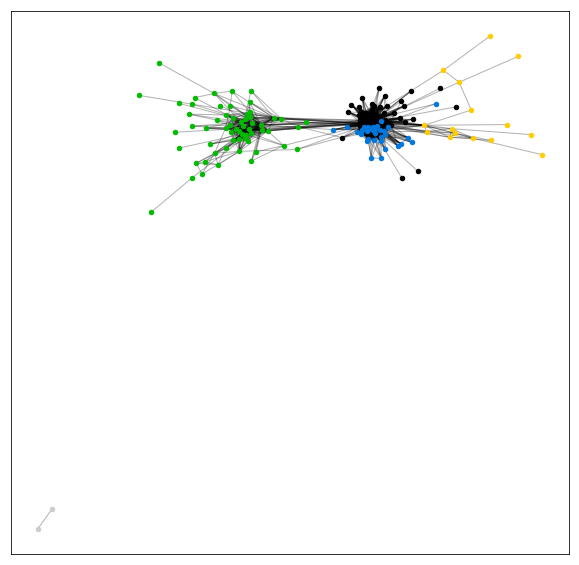

In [13]:
import networkx as nx

logging.info('Visualize components')
plt.figure(figsize=(10, 10)) 
size = float(len(components))
pos = nx.spring_layout(analyzer.CG)
cmap = plt.cm.get_cmap('nipy_spectral', len(set(pm.values())))
for i, com in enumerate(components):
    list_nodes = [node for node in pm.keys() if pm[node] == com]
    nx.draw_networkx_nodes(analyzer.CG, pos, list_nodes, node_size = 20, node_color = [cmap(i)])

nx.draw_networkx_edges(analyzer.CG, pos, alpha=0.3)
plt.show()

In [14]:
df_comp = pd.Series(pm).reset_index().rename(columns={'index': 'pmid', 0: 'comp'})
df_all = pd.merge(df_all, df_comp, on='pmid')
df_all.head()

,pmid,title,year,1985,1986,1988,1990,1991,1992,1993,...,2012,2013,2014,2015,2016,2017,2018,2019,total,comp
0,1722018,DNA methylation and cellular ageing.,1991,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8.0,3
1,2777259,Cytosine methylation and the fate of CpG dinuc...,1989,0.0,0.0,0.0,5.0,6.0,5.0,2.0,...,5.0,7.0,7.0,5.0,9.0,2.0,1.0,0.0,103.0,3
2,14577056,Genes of aging.,2003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,3
3,15790588,"Deregulated expression of the PER1, PER2 and P...",2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,11.0,14.0,7.0,8.0,11.0,13.0,0.0,119.0,2
4,15860628,PERIOD1-associated proteins modulate the negat...,2005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,12.0,9.0,7.0,7.0,7.0,5.0,0.0,97.0,2


In [15]:
years = df_all.columns.values[3:-2].astype(int)
min_year, max_year = np.min(years), np.max(years)

In [16]:
logging.info('Summary component detailed info visualization')

n_comps = df_all['comp'].nunique()
cmap = plt.cm.get_cmap('nipy_spectral', n_comps)
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(n_comps)]

components = [str(i) for i in range(n_comps)]
years = [str(y) for y in range(min_year, max_year)]
data = {'years': years}
for c in range(n_comps):
    data[str(c)] = [len(df_all[np.logical_and(df_all['comp'] == c, df_all['year'] == y)]) \
                    for y in range(min_year, max_year)]

p = figure(x_range=years, plot_width=960, plot_height=300, title="Components by Year",
           toolbar_location=None, tools="hover", tooltips="$name @components: @$name")

p.vbar_stack(components, x='years', width=0.9, color=palette, source=data, alpha=0.5,
             legend=[value(c) for c in components])

p.y_range.start = 0
p.x_range.range_padding = 0.1
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.legend.orientation = "horizontal"

show(p)

2019-05-03 09:17:54,410 INFO: Summary component detailed info visualization


In [17]:
logging.info('Per component detailed info visualization')
n_comps = df_all['comp'].nunique()
ds = [None] * n_comps
layouts = [None] * n_comps
most_common = [None] * n_comps
cmap = plt.cm.get_cmap('nipy_spectral', n_comps)
for c in range(n_comps):
    ds[c] = build_data_source(df_all[df_all['comp'] == c])
    most_common[c] = dict(get_most_common_ngrams(df_all[df_all['comp'] == c]['title'].values))
    kwd = ', '.join([f'{k} ({v:.2f})' for k, v in most_common[c].items()])
    title = f'Subtopic #{c}: {kwd}'
    layouts[c] = serve_scatter_article_layout(ds[c], title, year_range=[min_year, max_year], 
                                              color=RGB(*[round(ch*255) for ch in cmap(c)[:3]]))
    show(layouts[c])

2019-05-03 09:17:54,673 INFO: Per component detailed info visualization


## Top Cited Papers Overall

In [18]:
df_all = df_all.sort_values(by='total', ascending=False)

In [19]:
THRESHOLD = 0.1 # 10 %
MAX_PAPERS = 100

In [20]:
print('TODO: color me by components colors')
papers_to_show = min(MAX_PAPERS, round(len(analyzer.cit_df) * THRESHOLD))
ds_top = build_data_source(df_all.iloc[:papers_to_show, :])
layout_top = serve_scatter_article_layout(ds_top, 'Top cited papers', year_range=[min_year, max_year])
show(layout_top)

TODO: color me by components colors


## Top Cited Papers for Each Year

In [21]:
max_gain_data = []
cols = df_all.columns[3:-2]
for i in range(len(cols)):
    max_gain = df_all[cols[i]].astype(int).max()
    if max_gain > 0:
        sel = df_all[df_all[cols[i]] == max_gain]
        max_gain_data.append([cols[i], sel['pmid'].values[0], 
                              sel['title'].values[0], max_gain])
        
max_gain_df = pd.DataFrame(max_gain_data, columns=['year', 'pmid', 'title', 'count'])
max_gain_df.head(20)

ds_max = ColumnDataSource(data=dict(year=max_gain_df['year'], pmid=max_gain_df['pmid'].astype(str),
                                   title=max_gain_df['title'], count=max_gain_df['count']))
factors=max_gain_df['pmid'].astype(str).unique()
cmap = plt.cm.get_cmap('nipy_spectral', len(factors))
palette = [RGB(*[round(c*255) for c in cmap(i)[:3]]) for i in range(len(factors))]
colors = factor_cmap('pmid', palette=palette, factors=factors)

year_range = [min_year, max_year]
p = figure(tools=TOOLS, toolbar_location="above", 
           plot_width=960, plot_height=300, x_range=year_range, title='Max gain')
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label = 'Number of citations'
p.hover.tooltips = [
    ("PMID", '@pmid'),
    ("Title", '@title'),
    ("Year", '@year'),
    ("Cited by", '@count papers in @year')
]

p.vbar(x='year', width=0.8, top='count', fill_alpha=0.5, source=ds_max, fill_color=colors, line_color=colors)

show(p)

## Citation per Year Dynamics

In [22]:
p, h, panel = serve_citation_dynamics_layout()